# Определение возраста покупателей по фотографии

Задачей этого проекта является построение модели для определения приблизительного возраста покупателя по фотографии. Для её решения загрузим данные, исследуем их, посмотрим на распределение целевого признака в выборке, затем проведём обучение модели и изучим результаты. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

Загрузим данные и посмотрим на размер выборки.

In [2]:
##Загружаем данные

df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки - 7591 изображения. Такого количества изображений для качественного обучения модели может не хватить. Поэтому при обучении стоит применить повороты изображений, чтобы увеличить выборку. 

Text(0, 0.5, 'Количество')

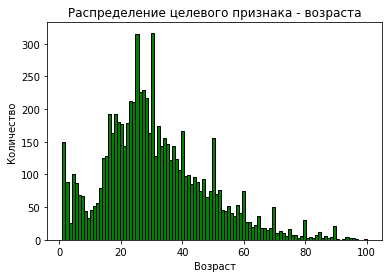

In [4]:
plt.hist(df['real_age'], color = 'green', edgecolor = 'black',
         bins = 100)

plt.title('Распределение целевого признака - возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')

На гистограмме мы видим нормальное распределение, которое скошено вправо за счет длинного хвоста возрастных покупателей. Также мы видим пики в круглых датах, что, скорее всего, указвает на то, что при разметке в случае сомнения возраст округляли, поэтому не все круглые возраста корректны. 

In [5]:
df['file_name']

0       000000.jpg
1       000001.jpg
2       000002.jpg
3       000003.jpg
4       000004.jpg
           ...    
7586    007608.jpg
7587    007609.jpg
7588    007610.jpg
7589    007611.jpg
7590    007612.jpg
Name: file_name, Length: 7591, dtype: object

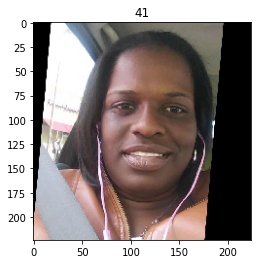

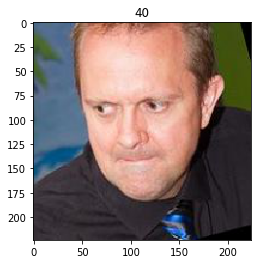

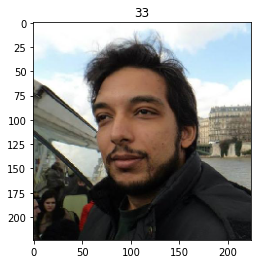

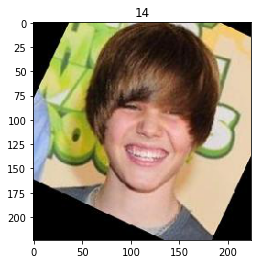

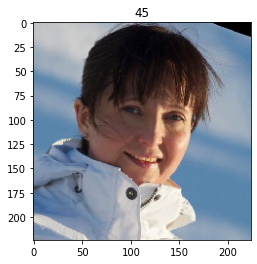

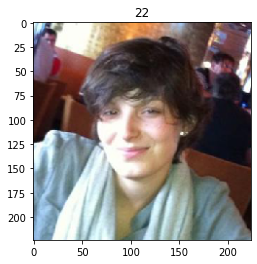

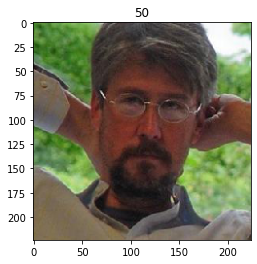

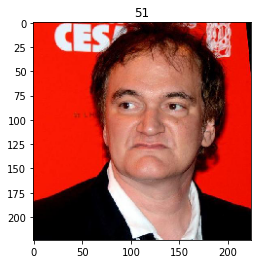

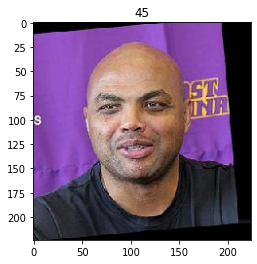

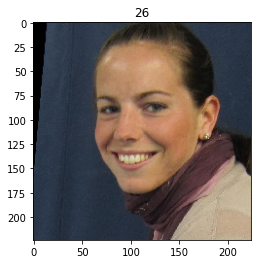

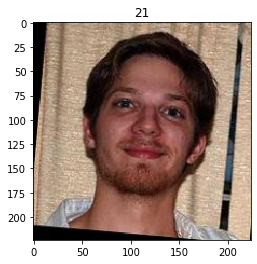

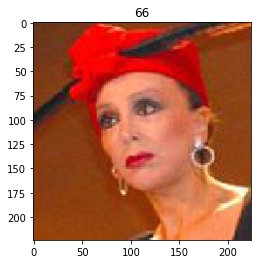

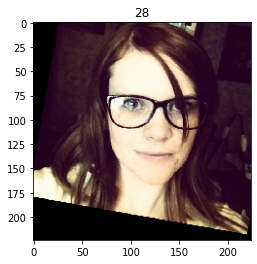

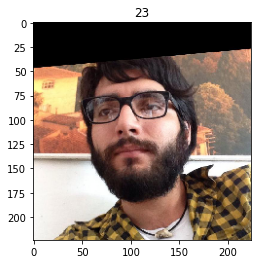

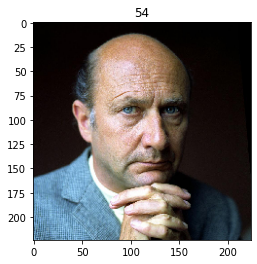

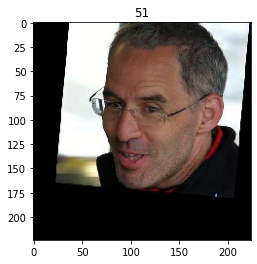

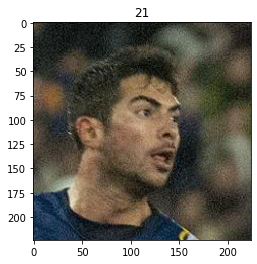

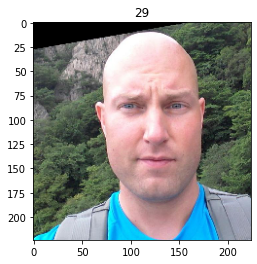

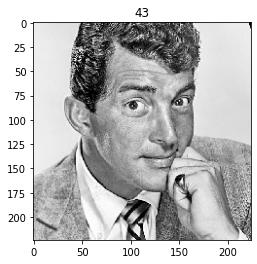

In [6]:
for i in range (1, 20):
    features, target = next(train_gen_flow)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.show()

Итак, для построения модели нам дан датасет с названиями файлов-фотографий и соответствующим возрастом, а также сами фотографии. Иследовательский анализ показал, что данные распределены нормально. Есть вопрос: является ли распределение в выборке репрезентативным в отношении генеральной совокупности. По данным Федеральной службы государственной статистики (https://infotables.ru/statistika/31-rossijskaya-federatsiya/783-raspredelenie-naseleniya-po-vozrastnym-gruppam-tablitsa) распределение населения России по возрасту несколько иное (например, доля пенсионеров в возрасте 60-70 лет явно больше). С другой стороны, возможно в выборке сделана поправка на распределение возраста покупателей именно нашего магазина. В любом случае, считаем, что этот момент необходимо выснить перед внедрением модели.

Напечатав несколько фотографий, мы убиделись, что, во-первых, возраст в выборке приблизительно соответствует фотографии, а во-вторых, что нам даны очень разноматсные фотографии - разного качества, с разных ракурсов. Некоторые фотографии чёрно-белые. Фотографии одного размера, некоторые повёрнуты под небольшим углом и тогда пустое место заполнено чёрным. Но поворот не настолько сильный, чтобы лицо искажалось и менялась ориентация изображения. Если модель научится работать с такими фотографими, то в реальной жизни она так же должна показать хорошие рузельтаты. 
Переходим к обучению модели.

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
 
 
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)
    return train_gen_flow
 
 
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory='/datasets/faces/final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)
    return test_gen_flow
 
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
 
    return model
 
 
 
def train_model(model, train_data, test_data, 
                batch_size=None, epochs=13,
                steps_per_epoch=None,
                validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2) 
 
    return model
```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
2023-02-04 10:48:45.755031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-02-04 10:48:45.951733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-02-04 10:48:50.341652: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-04 10:48:51.024730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-04 10:48:51.024821: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-04 10:48:51.024854: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-04 10:48:51.104230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-04 10:48:51.124504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-04 10:48:51.449772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-04 10:48:51.487917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-04 10:48:51.488053: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-04 10:48:51.492711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-02-04 10:48:52.931050: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-02-04 10:48:52.963889: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-02-04 10:48:52.965850: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4722b50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-04 10:48:52.965884: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-04 10:48:53.158765: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3f5e050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-04 10:48:53.158802: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-02-04 10:48:53.161186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-04 10:48:53.161250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-04 10:48:53.161260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-04 10:48:53.161290: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-04 10:48:53.161300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-04 10:48:53.161311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-04 10:48:53.161320: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-04 10:48:53.161328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-04 10:48:53.165610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-02-04 10:48:53.167578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-04 10:48:56.552221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-04 10:48:56.552269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-02-04 10:48:56.552280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-02-04 10:48:56.557135: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-04 10:48:56.557200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/13
2023-02-04 10:49:20.691310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-04 10:49:22.789941: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 203.7572 - mean_absolute_error: 10.7729 - val_loss: 292.9130 - val_mean_absolute_error: 12.8667
Epoch 2/13
356/356 - 39s - loss: 131.8099 - mean_absolute_error: 8.8360 - val_loss: 221.1229 - val_mean_absolute_error: 11.5937
Epoch 3/13
356/356 - 39s - loss: 113.2673 - mean_absolute_error: 8.1488 - val_loss: 122.8082 - val_mean_absolute_error: 8.6759
Epoch 4/13
356/356 - 39s - loss: 89.2381 - mean_absolute_error: 7.1941 - val_loss: 124.2009 - val_mean_absolute_error: 8.5377
Epoch 5/13
356/356 - 39s - loss: 83.1027 - mean_absolute_error: 6.9284 - val_loss: 92.1739 - val_mean_absolute_error: 7.3604
Epoch 6/13
356/356 - 39s - loss: 68.2114 - mean_absolute_error: 6.3309 - val_loss: 102.7495 - val_mean_absolute_error: 7.6305
Epoch 7/13
356/356 - 39s - loss: 52.8893 - mean_absolute_error: 5.6053 - val_loss: 98.6600 - val_mean_absolute_error: 7.4830
Epoch 8/13
356/356 - 39s - loss: 43.2273 - mean_absolute_error: 5.0949 - val_loss: 98.9880 - val_mean_absolute_error: 7.4816
Epoch 9/13
356/356 - 39s - loss: 38.6337 - mean_absolute_error: 4.7853 - val_loss: 120.9770 - val_mean_absolute_error: 8.2687
Epoch 10/13
356/356 - 38s - loss: 37.9972 - mean_absolute_error: 4.7457 - val_loss: 91.5964 - val_mean_absolute_error: 7.1657
Epoch 11/13
356/356 - 38s - loss: 32.6368 - mean_absolute_error: 4.4249 - val_loss: 99.1267 - val_mean_absolute_error: 7.6210
Epoch 12/13

```

## Анализ обученной модели

Во время обучения модели мы пробовали применить разные архитектуры, функции потерь и параметры. В итоге для построения успешной модели (которая и приведена в проекте) мы использовали архитектуру ResNet50. По результатам обучения нам удaлось добиться значения средней абсолютной ошибки - 7.6210. В выводе результатов модели на экран можно увидеть, как с каждой эпохой уменьшалась функция потерь. Считаем, что модель справляется со своей задачей. 